## Evaluation of the models (ResNet and ViT)

**ResNet:** This model includes a series of convolutional layers with skip connections, global average pooling, and integrates low-level features via a skip connection from the input. It is tailored for complex pattern recognition in data with spatial dimension (adopted from https://arxiv.org/pdf/2301.10343).

**ViT (Vision Transformer):** This configuration features multi-scale convolutional patch embedding with residual connections, followed by a series of transformer blocks. The model processes input data to generate an output with the same spatial dimensions, applying learnable positional encodings and a final dense layer for regression (https://arxiv.org/pdf/2410.12728).

Models were trained on historical data using air temperature and sea-level pressure as a predictors, and residuals (observational - cmip6) as the target variable. Estimated residuals were added back to bilinearly interpolated CMIP6 data (resampled to the observational data's spatial resolution) to evaluate models' performance.


The data from CNRM-ESM2-1 for historical and SSP585 scenario. 
The historical data were split using as follows: training from 1950-2004, validation from 2004-2009, and testing from 2010-2014.

#### Define Functions for data loading and plotting

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')
import xarray as xr
import numpy as np

def load_and_mean_data(files_or_path, var_name, start_year=None, end_year=None, mask=None, lat=None, lon=None, interp_method=None, is_zarr=False):
  
    if is_zarr:
        ds = xr.open_zarr(files_or_path, consolidated=True)
    else:
        ds = xr.open_mfdataset(files_or_path, combine='by_coords', chunks={'time': -1})

    # Select time range based on start and end years
    if 'time' in ds.coords and hasattr(ds.time.dt, 'year'):
        if start_year is not None:
            ds = ds.sel(time=ds.time.dt.year >= start_year)
        if end_year is not None:
            ds = ds.sel(time=ds.time.dt.year <= end_year)
    elif start_year is not None or end_year is not None:
        print("Warning: start_year and end_year provided, but 'time' coordinate not found or doesn't have a 'year' attribute. Ignoring year selection.")


    data_mean = ds[var_name].mean(dim='time')

    # Interpolate if lat/lon are provided
    if lat is not None and lon is not None and interp_method:
        data_mean = data_mean.interp(lat=lat, lon=lon, method=interp_method, kwargs={"fill_value": "extrapolate"})

    # Apply mask if provided
    if mask is not None:
        data_mean = data_mean.where(~mask, np.nan)

    return data_mean

# Function to plot mean temperature maps
def plot_map(data, ax, title, mean_value, vmin=270, vmax=292, cmap='RdBu_r'):
    data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
        cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.8, 'aspect': 30, 'label': 'Mean Temperature (K)'}
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(title)
    ax.text(10, 50.5, f'Mean: {mean_value:.2f} K', fontsize=10, ha='center', va='center', color='black')

# Function to calculate RMSE and MAE
def calculate_rmse_mae(model1, model2):
    diff = model1 - model2
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

## Load and plot historical and SSP245 data
Load the datasets (CMIP6, NEX-GDDP, ResNet and ViT), calculate the multiannual means, and plot the results.

#### Historical

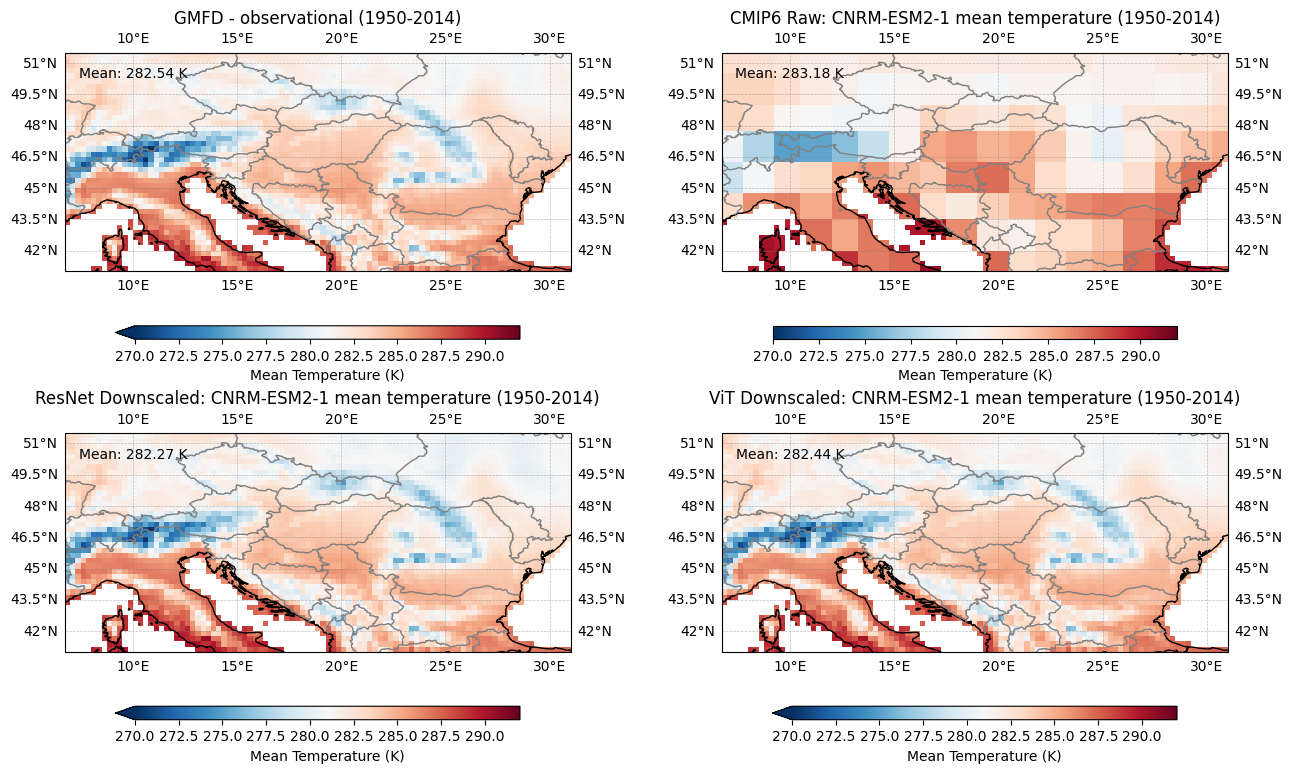

In [2]:
# Define file paths for historical data
nexgddp_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/CNRM-ESM2-1'
cmip6_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1'

nexgddp_hist_files = [f'{nexgddp_base_path}/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_{year}_rou.nc' for year in range(1950, 2015)]
cmip6_hist_file = f'{cmip6_base_path}/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
vit_hist_file = 'ncs/vit/predicted_high_res_tas_vit.nc'
resnet_hist_file = 'ncs/resnet/predicted_high_res_tas_resnet.nc'


# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1950, end_year = 2014)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon


# Load CMIP6 data and interpolate
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1950, end_year = 2014)

# Load ResNet and ViT downscaled data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)
resnet_mean_hist = load_and_mean_data(resnet_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)


# Load GMFD observatinal data
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_mean_hist = load_and_mean_data(gmfd_files, 'tas', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)


# Plot multiannual means for historical data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset for historical data
plot_map(gmfd_mean_hist, axs[0, 0], 'GMFD - observational (1950-2014)', gmfd_mean_hist.mean().values)
plot_map(cmip6_mean_hist, axs[0, 1], 'CMIP6 Raw: CNRM-ESM2-1 mean temperature (1950-2014)', cmip6_mean_hist.mean().values)
plot_map(resnet_mean_hist, axs[1, 0], 'ResNet Downscaled: CNRM-ESM2-1 mean temperature (1950-2014)',resnet_mean_hist.mean().values)
plot_map(vit_mean_hist, axs[1, 1], 'ViT Downscaled: CNRM-ESM2-1 mean temperature (1950-2014)', vit_mean_hist.mean().values)
# Leave axs[0, 1] empty as requested
plt.show()

### SSP 126

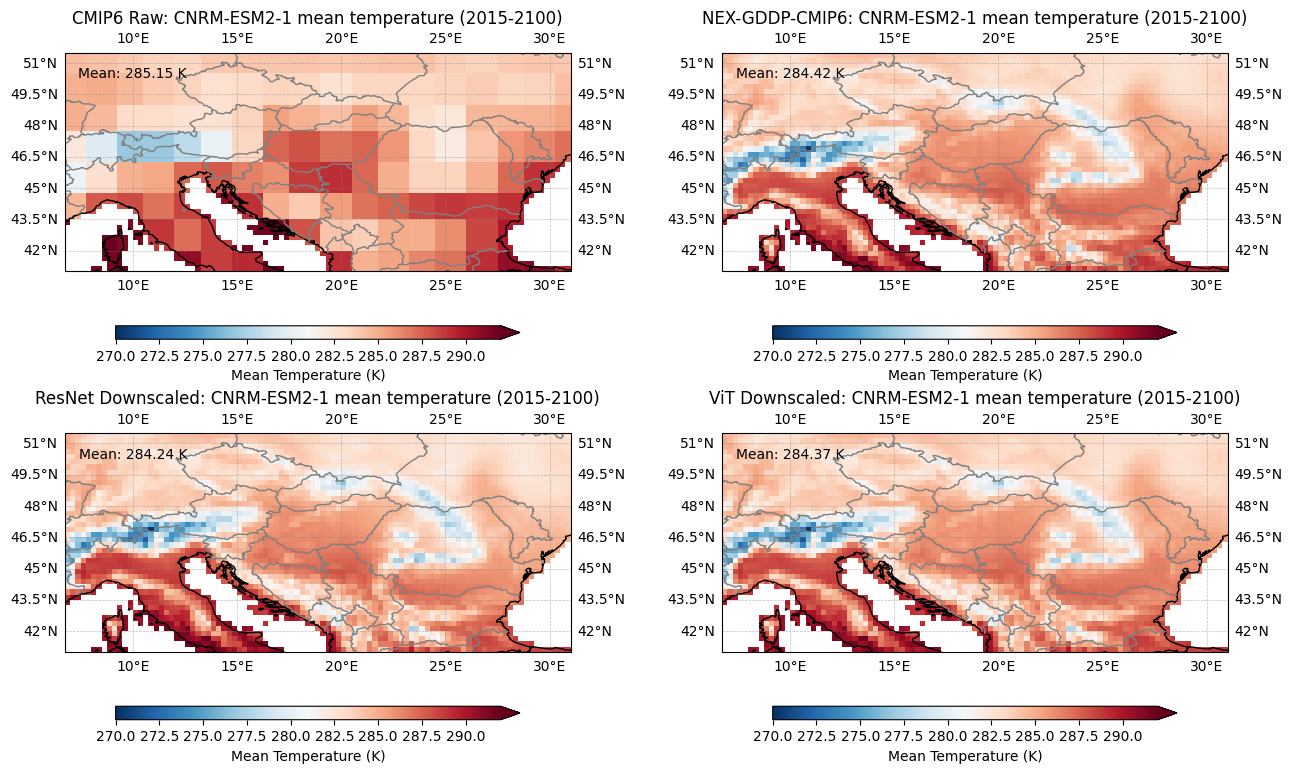

In [3]:
directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/CNRM-ESM2-1/ssp126/r1i1p1f2/tas/'
# List all .nc files in the directory (non-recursive)
nexgddp_ssp_files  = glob.glob(f'{directory}/*.nc')
cmip6_ssp_file = f'{cmip6_base_path}/ssp126/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
vit_ssp_file = 'ncs/vit/predicted_high_res_tas_vit_ssp126.nc'
resnet_ssp_file = 'ncs/resnet/predicted_high_res_tas_resnet_ssp126.nc'

# Load NEX-GDDP SSP126 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP126 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load ResNet and ViT downscaled data for SSP126
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
resnet_mean_ssp = load_and_mean_data(resnet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP126 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw: CNRM-ESM2-1 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values)
plot_map(resnet_mean_ssp, axs[1, 0], 'ResNet Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)',resnet_mean_ssp.mean().values)
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)', vit_mean_ssp.mean().values)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

#### Climate change signal

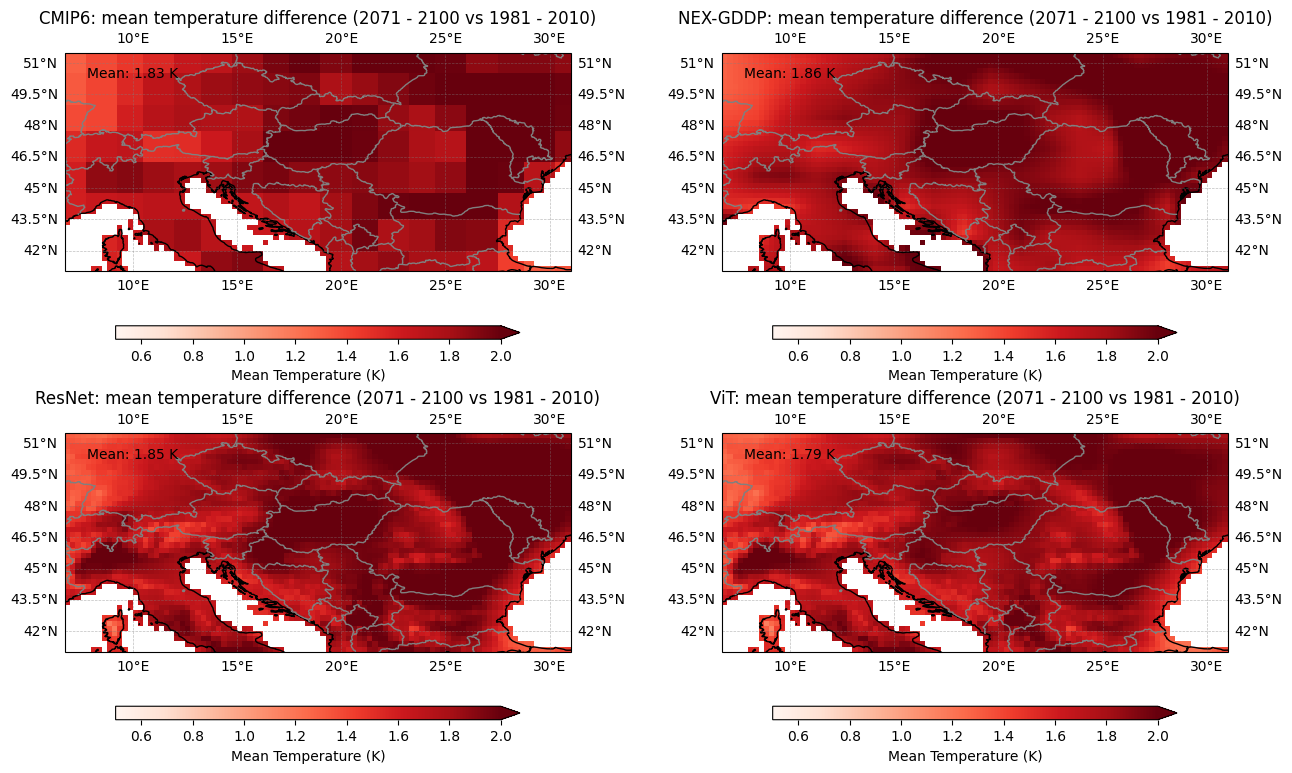

In [4]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon

# Load CMIP6 data and interpolate to observational resolution
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)

# Load ResNet and ViT downscaled historical data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
resnet_mean_hist = load_and_mean_data(resnet_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load ResNet and Vit downscaled data for SSP245
resnet_mean_ssp = load_and_mean_data(resnet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
resnet_mean_change = resnet_mean_ssp - resnet_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=0.5, vmax=2, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=0.5, vmax=2, cmap='Reds')
plot_map(resnet_mean_change, axs[1, 0], 'ResNet: mean temperature difference (2071 - 2100 vs 1981 - 2010)', resnet_mean_change.mean().values, vmin=0.5, vmax=2, cmap='Reds')
plot_map(vit_mean_change, axs[1, 1], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=0.5, vmax=2, cmap='Reds')

#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

#### Annual time serie plot

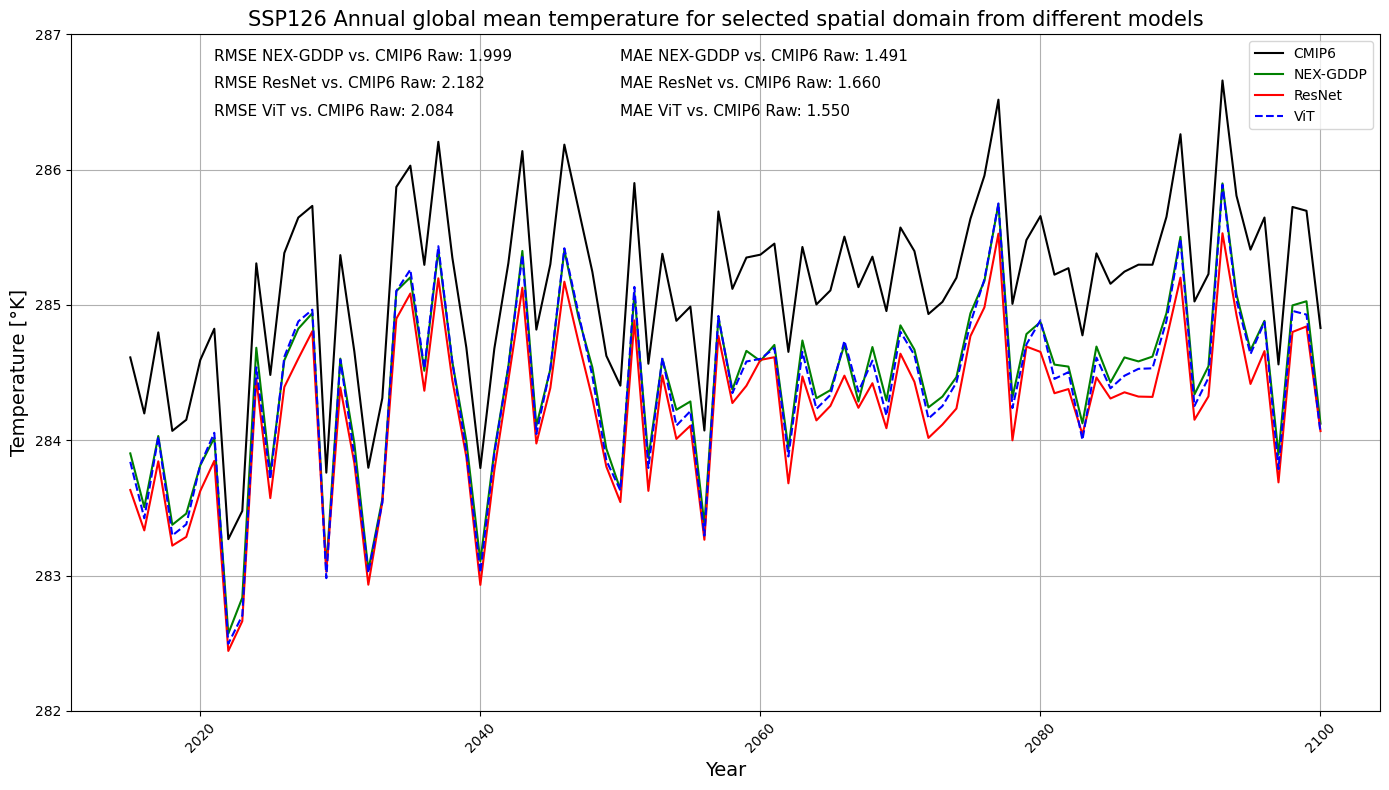

RMSE and MAE values:
NEX-GDDP: RMSE = 1.999, MAE = 1.491
ResNet: RMSE = 2.182, MAE = 1.660
ViT: RMSE = 2.084, MAE = 1.550


In [5]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load and process ResNet data
resnet_ds = xr.open_dataset(resnet_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
resnet_annual = resnet_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
resnet_global_mean = resnet_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, resnet_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_annual.values, nexgddp_annual.values),
                       calculate_rmse_mae(cmip6_annual.values, resnet_annual.values),
                      calculate_rmse_mae(cmip6_annual.values, vit_annual.values))

nexgddp_global_mean, cmip6_global_mean, resnet_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_resnet, mae_resnet), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(14, 8))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, resnet_global_mean.values, label='ResNet', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
plt.title('SSP126 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature [°K]', fontsize=14)
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Adjust text_y_positions to have enough elements
text_y_positions = [ 286.8, 286.6, 286.4]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_resnet, rmse_vit],
        [mae_nexgddp, mae_resnet, mae_vit],
        ['NEX-GDDP', 'ResNet', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(282, 287)
plt.tight_layout()
plt.show()

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"ResNet: RMSE = {rmse_resnet:.3f}, MAE = {mae_resnet:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")

#### Print accuracy indicators

In [6]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
cmip6_monthly = load_and_process(cmip6_ssp_file) 
resnet_monthly = load_and_process(resnet_ssp_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, resnet_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, resnet_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
resnet_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "ResNet RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "ResNet MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_resnet, mae_resnet = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["ResNet RMSE"].append(rmse_resnet)
    metrics["ResNet MAE"].append(mae_resnet)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','ResNet RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','ResNet MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


Table 1: Root Mean Squared Error (RMSE) by Model and Month
     Month        NEX-GDDP RMSE    ResNet RMSE      ViT RMSE   
     January         2.010           2.006           2.123     
    February         2.077           1.967           2.104     
       March         1.919           2.009           2.073     
       April         1.887           2.219           2.056     
         May         1.956           2.430           2.075     
        June         2.297           2.675           2.137     
        July         2.688           2.844           2.187     
      August         2.810           2.841           2.178     
   September         2.539           2.622           2.126     
     October         1.913           2.319           2.079     
    November         1.911           2.037           2.081     
    December         2.012           1.954           2.105     

Table 2: Mean Absolute Error (MAE) by Model and Month
     Month        NEX-GDDP MAE     ResNet MAE        V

#### Time series plots for January and July

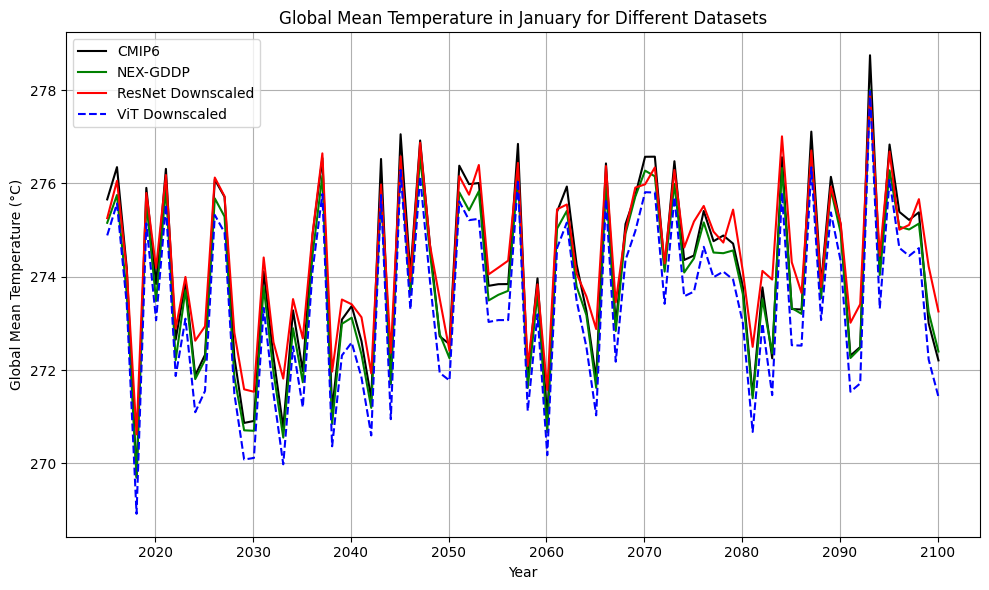

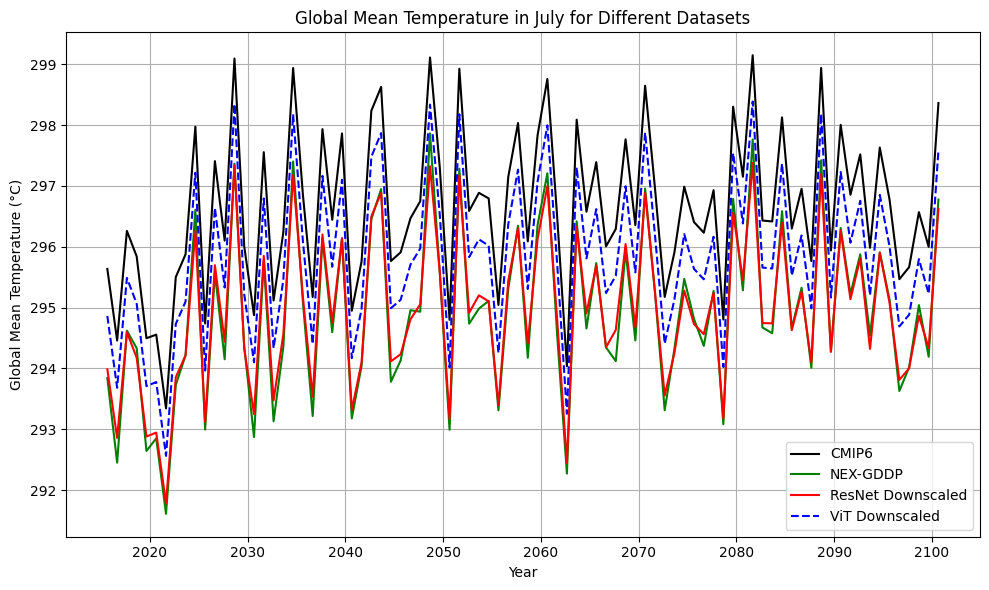

In [7]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
resnet_january = resnet_global_mean_monthly.sel(time=resnet_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(resnet_january['time'], resnet_january, label='ResNet Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
resnet_january = resnet_global_mean_monthly.sel(time=resnet_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(resnet_january['time'], resnet_january, label='ResNet Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### SSP 245

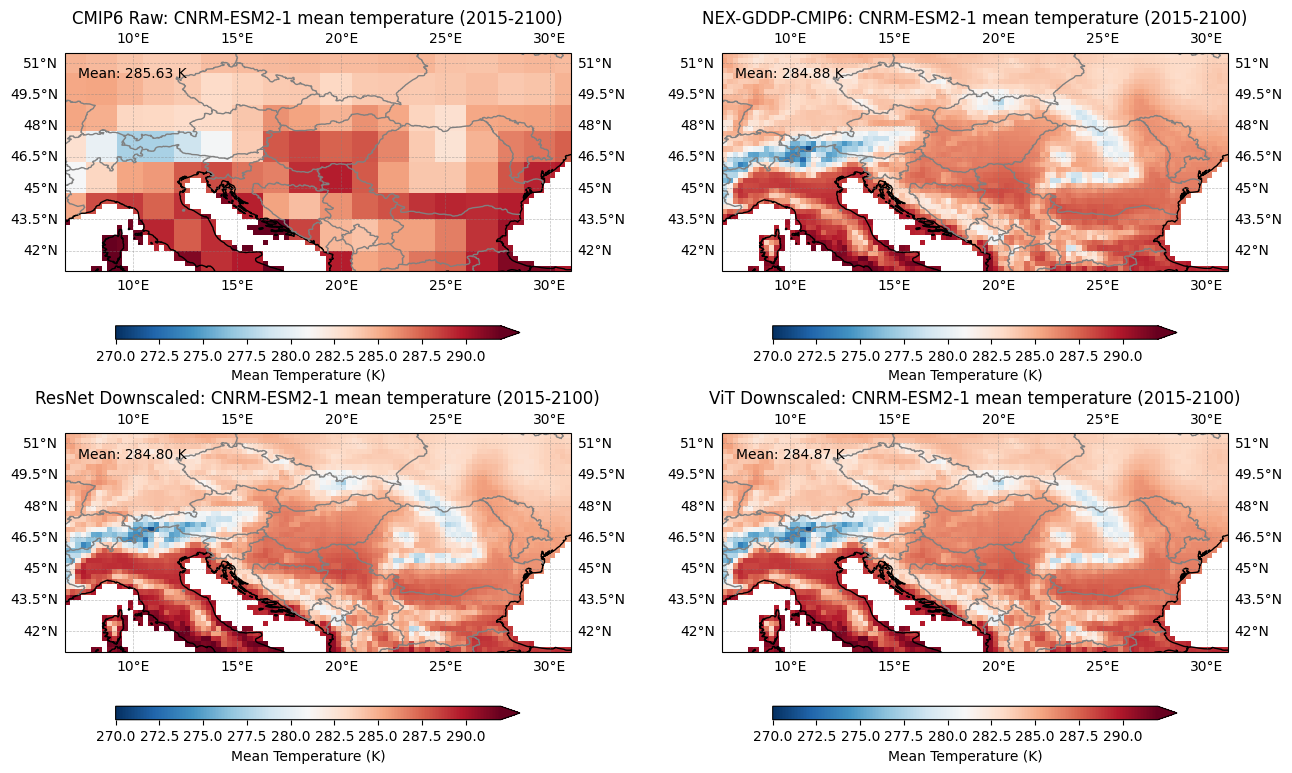

In [8]:
# Define file paths for SSP245 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
vit_ssp_file = 'ncs/vit/predicted_high_res_tas_vit_ssp245.nc'
resnet_ssp_file = 'ncs/resnet/predicted_high_res_tas_resnet_ssp245.nc'

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load ResNet and ViT downscaled data for SSP245
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
resnet_mean_ssp = load_and_mean_data(resnet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP245 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw: CNRM-ESM2-1 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values)
plot_map(resnet_mean_ssp, axs[1, 0], 'ResNet Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)',resnet_mean_ssp.mean().values)
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)', vit_mean_ssp.mean().values)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

#### Climat change signal
Here the changes are computed for the 2071-2100 mean against the 1981-2100.

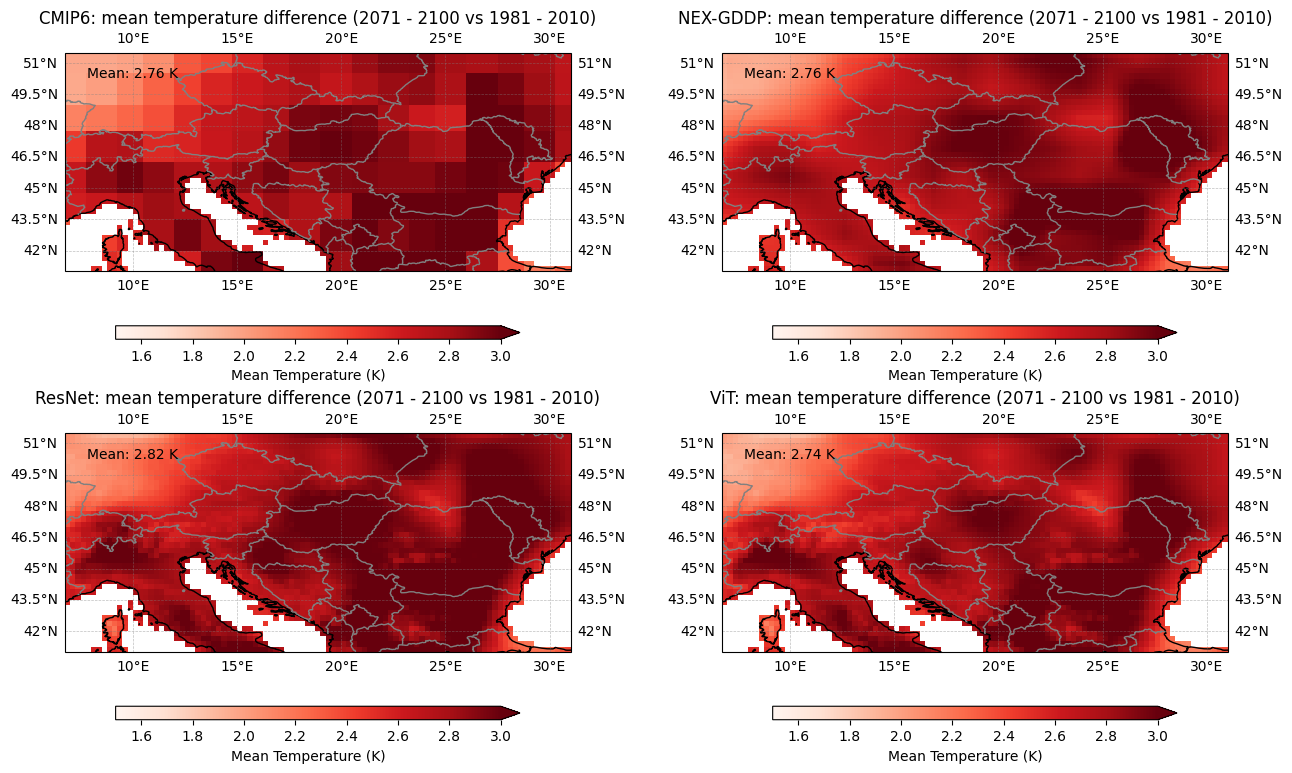

In [9]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon

# Load CMIP6 data and interpolate to observational resolution
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)

# Load ResNet and ViT downscaled historical data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
resnet_mean_hist = load_and_mean_data(resnet_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load ResNet and Vit downscaled data for SSP245
resnet_mean_ssp = load_and_mean_data(resnet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
resnet_mean_change = resnet_mean_ssp - resnet_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(resnet_mean_change, axs[1, 0], 'ResNet: mean temperature difference (2071 - 2100 vs 1981 - 2010)', resnet_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(vit_mean_change, axs[1, 1], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')

#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

#### Calculate RMSE and MAE for SSP245 and plot time series of the annual and montly global mean for the selected domain

Calculate the RMSE and MAE between the downscaled models (NEX-GDDP, ResNet and ViT) and the CMIP6 raw data for the SSP245 scenario, for yearly data for all pixels from the domain.

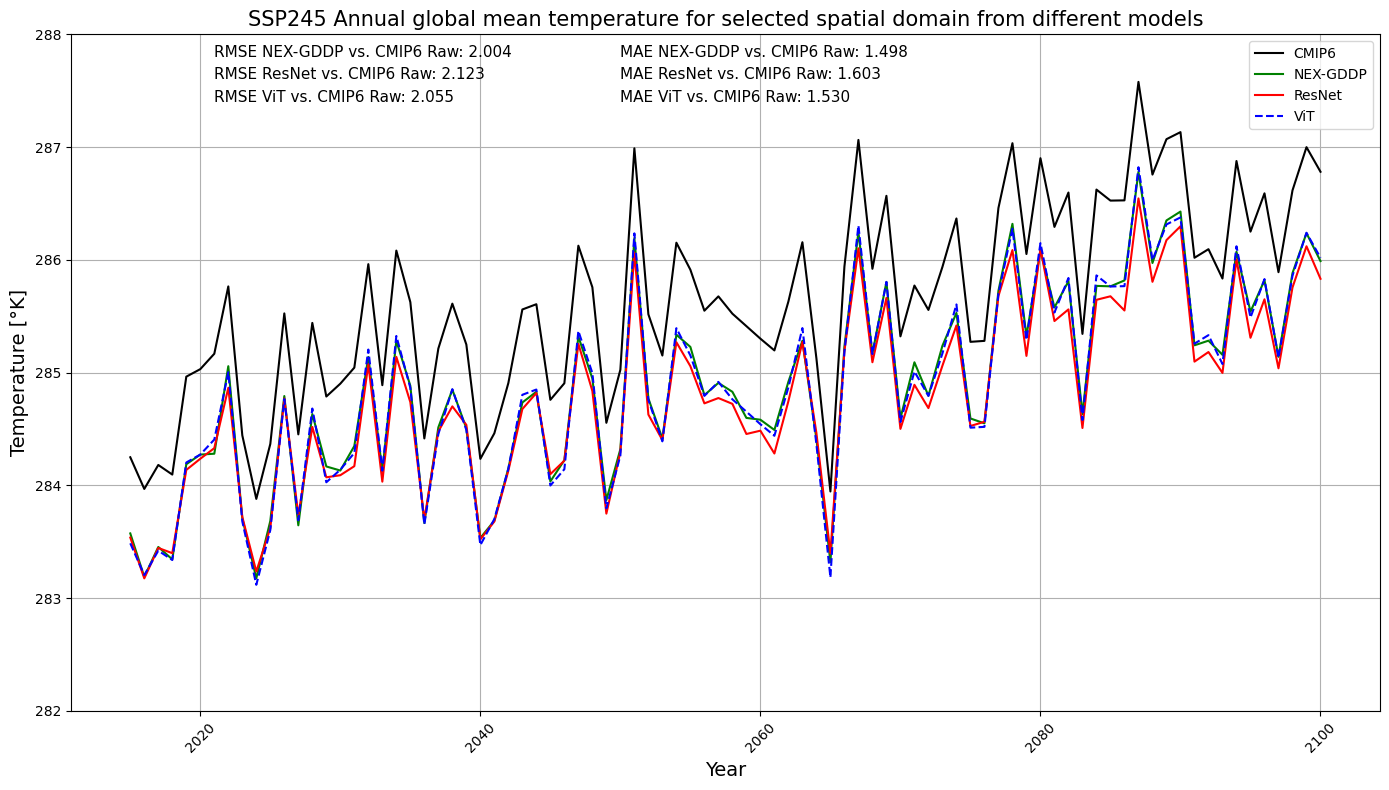

RMSE and MAE values:
NEX-GDDP: RMSE = 2.004, MAE = 1.498
ResNet: RMSE = 2.123, MAE = 1.603
ViT: RMSE = 2.055, MAE = 1.530


In [10]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load and process ResNet data
resnet_ds = xr.open_dataset(resnet_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
resnet_annual = resnet_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
resnet_global_mean = resnet_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, resnet_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_annual.values, nexgddp_annual.values),
                       calculate_rmse_mae(cmip6_annual.values, resnet_annual.values),
                      calculate_rmse_mae(cmip6_annual.values, vit_annual.values))

nexgddp_global_mean, cmip6_global_mean, resnet_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_resnet, mae_resnet), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(14, 8))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, resnet_global_mean.values, label='ResNet', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
plt.title('SSP245 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature [°K]', fontsize=14)
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Adjust text_y_positions to have enough elements
text_y_positions = [287.8, 287.6, 287.4, 287.2, 287]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_resnet, rmse_vit],
        [mae_nexgddp, mae_resnet, mae_vit],
        ['NEX-GDDP', 'ResNet', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(282, 288)
plt.tight_layout()
plt.show()

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"ResNet: RMSE = {rmse_resnet:.3f}, MAE = {mae_resnet:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")

#### Print accuracy metrics for each month

In [11]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
cmip6_monthly = load_and_process(cmip6_ssp_file) 
resnet_monthly = load_and_process(resnet_ssp_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, resnet_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, resnet_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
resnet_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "ResNet RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "ResNet MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_resnet, mae_resnet = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["ResNet RMSE"].append(rmse_resnet)
    metrics["ResNet MAE"].append(mae_resnet)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','ResNet RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','ResNet MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


Table 1: Root Mean Squared Error (RMSE) by Model and Month
     Month        NEX-GDDP RMSE    ResNet RMSE      ViT RMSE   
     January         2.004           2.011           2.089     
    February         2.084           1.946           2.072     
       March         1.910           1.975           2.036     
       April         1.889           2.130           2.026     
         May         1.951           2.344           2.042     
        June         2.295           2.599           2.110     
        July         2.711           2.780           2.165     
      August         2.830           2.775           2.157     
   September         2.552           2.570           2.103     
     October         1.909           2.268           2.053     
    November         1.903           1.999           2.051     
    December         2.018           1.935           2.078     

Table 2: Mean Absolute Error (MAE) by Model and Month
     Month        NEX-GDDP MAE     ResNet MAE        V

#### Plot January and July

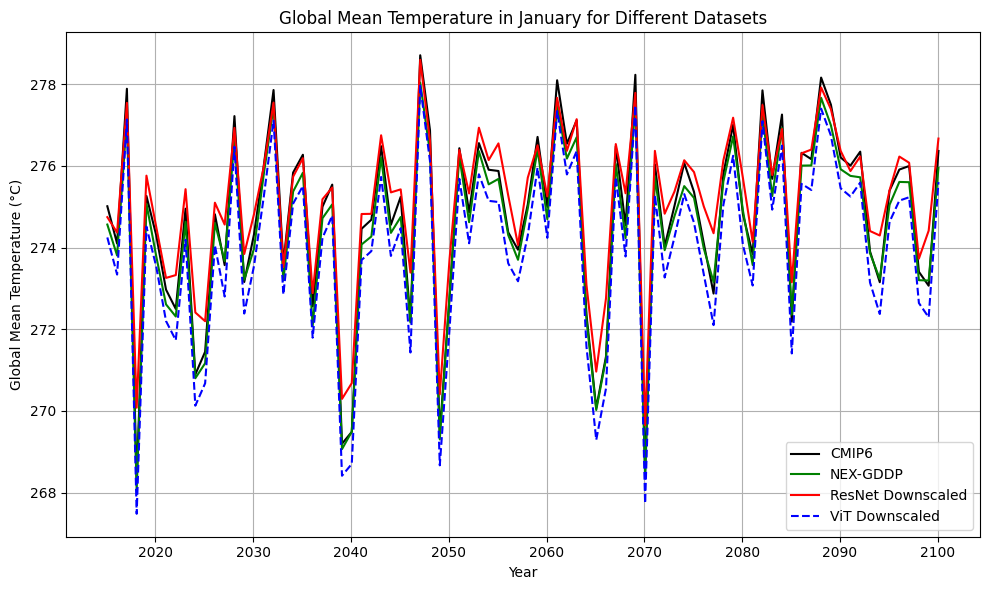

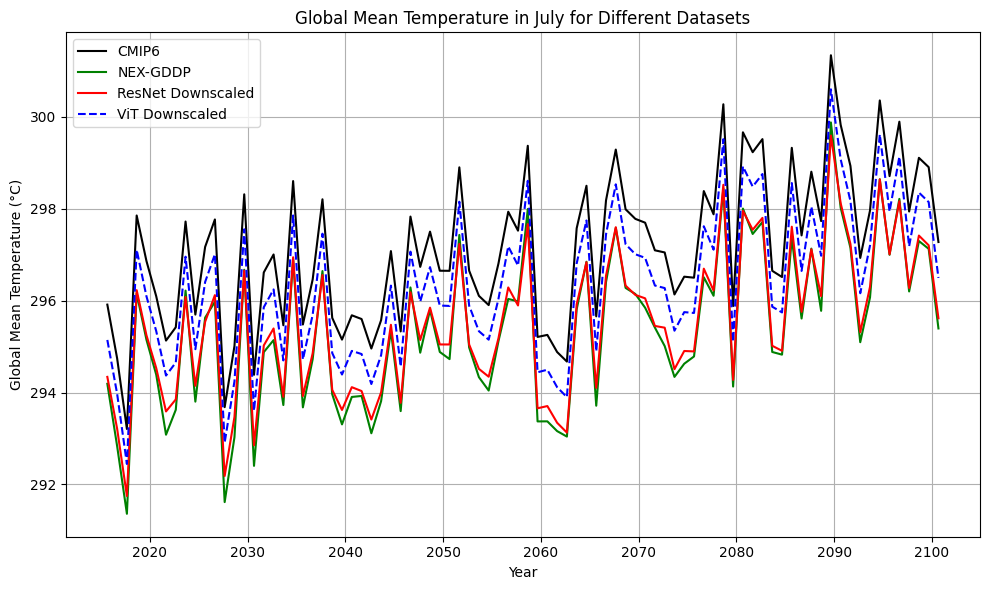

In [12]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
resnet_january = resnet_global_mean_monthly.sel(time=resnet_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(resnet_january['time'], resnet_january, label='ResNet Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
resnet_january = resnet_global_mean_monthly.sel(time=resnet_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(resnet_january['time'], resnet_january, label='ResNet Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### SSP 585

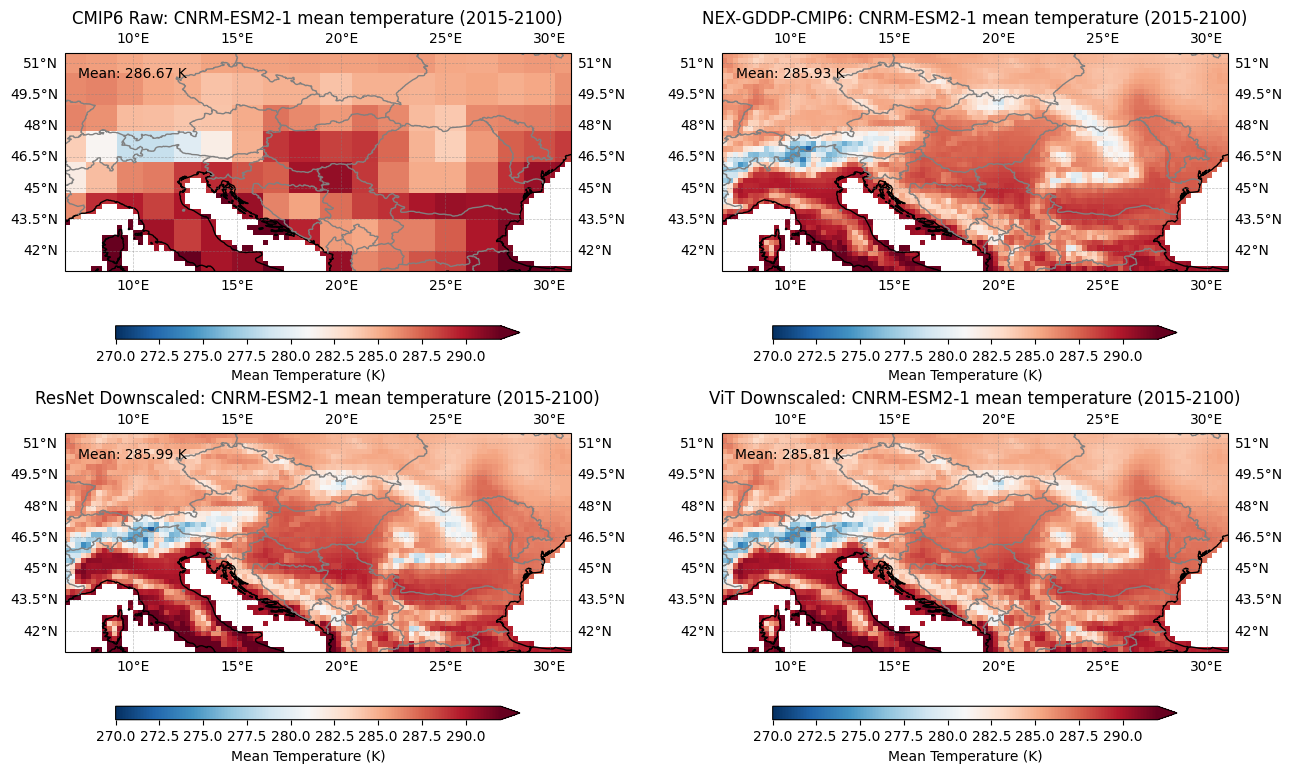

In [13]:
# Define file paths for SSP585 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
vit_ssp_file = 'ncs/vit/predicted_high_res_tas_vit_ssp585.nc'
resnet_ssp_file = 'ncs/resnet/predicted_high_res_tas_resnet_ssp585.nc'

# Load NEX-GDDP SSP585 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP585 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load ResNet and ViT downscaled data for SSP585
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
resnet_mean_ssp = load_and_mean_data(resnet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP585 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw: CNRM-ESM2-1 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values)
plot_map(resnet_mean_ssp, axs[1, 0], 'ResNet Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)',resnet_mean_ssp.mean().values)
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)', vit_mean_ssp.mean().values)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

##### Climate change signal

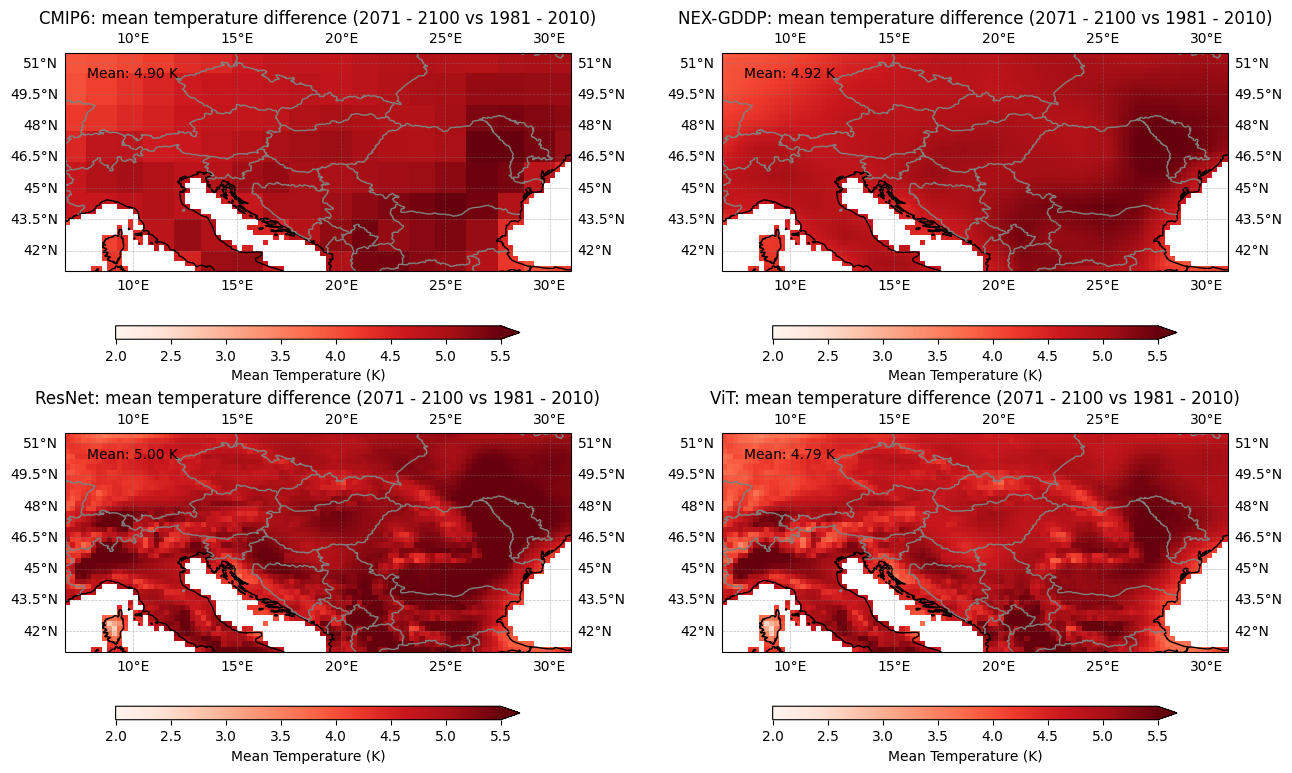

In [14]:
# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load ResNet and Vit downscaled data for SSP245
resnet_mean_ssp = load_and_mean_data(resnet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
resnet_mean_change = resnet_mean_ssp - resnet_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=2, vmax=5.5, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=2, vmax=5.5, cmap='Reds')
plot_map(resnet_mean_change, axs[1, 0], 'ResNet: mean temperature difference (2071 - 2100 vs 1981 - 2010)', resnet_mean_change.mean().values, vmin=2, vmax=5.5, cmap='Reds')
plot_map(vit_mean_change, axs[1, 1], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=2, vmax=5.5, cmap='Reds')

#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

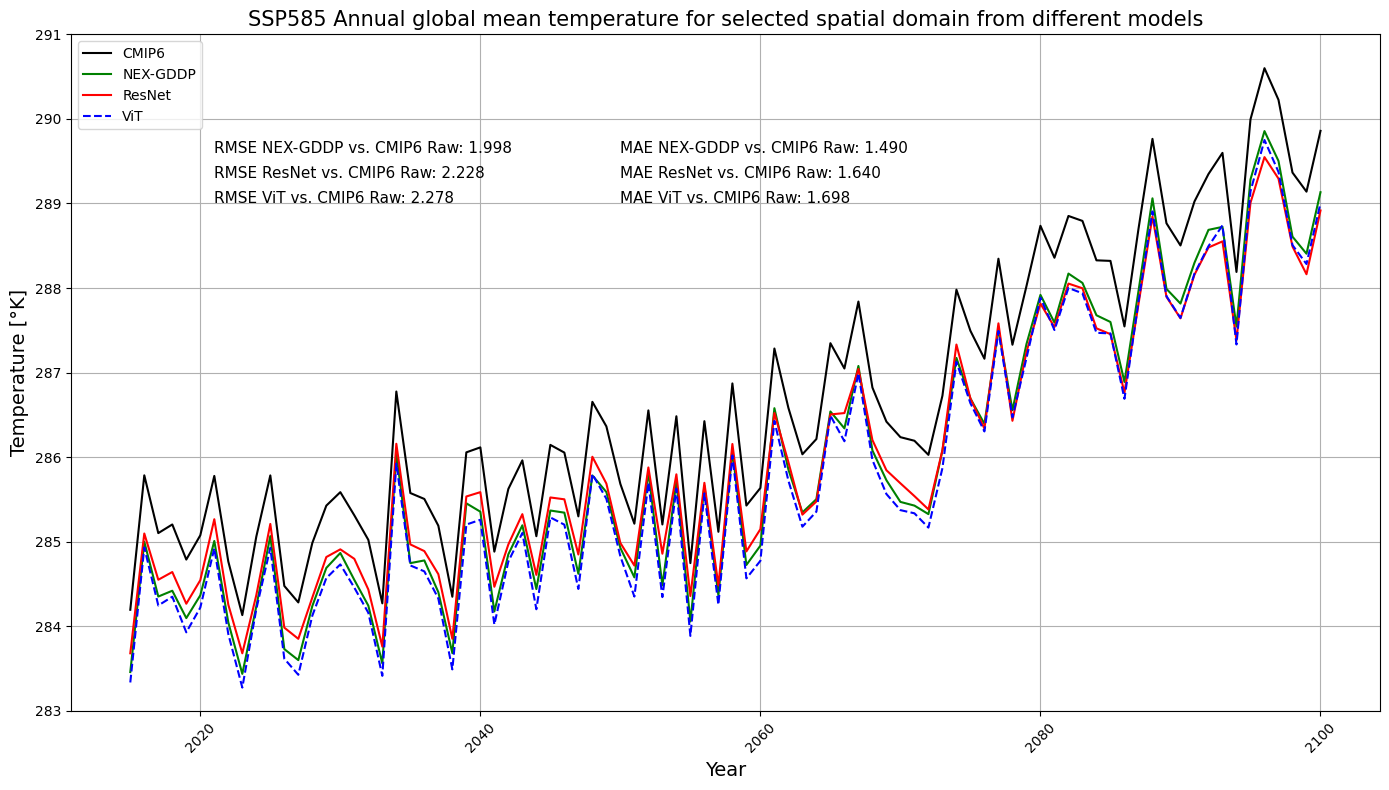

RMSE and MAE values:
NEX-GDDP: RMSE = 1.998, MAE = 1.490
ResNet: RMSE = 2.228, MAE = 1.640
ViT: RMSE = 2.278, MAE = 1.698


In [15]:
# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load and process ResNet data
resnet_ds = xr.open_dataset(resnet_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
resnet_annual = resnet_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
resnet_global_mean = resnet_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, resnet_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_annual.values, nexgddp_annual.values),
                       calculate_rmse_mae(cmip6_annual.values, resnet_annual.values),
                      calculate_rmse_mae(cmip6_annual.values, vit_annual.values))

nexgddp_global_mean, cmip6_global_mean, resnet_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_resnet, mae_resnet), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(14, 8))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, resnet_global_mean.values, label='ResNet', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
plt.title('SSP585 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature [°K]', fontsize=14)
plt.legend(loc='upper left') 
plt.grid()
plt.xticks(rotation=45)

# Adjust text_y_positions to have enough elements
text_y_positions = [289.6, 289.3, 289]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_resnet, rmse_vit],
        [mae_nexgddp, mae_resnet, mae_vit],
        ['NEX-GDDP', 'ResNet', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(283, 291)
plt.tight_layout()
plt.show()

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"ResNet: RMSE = {rmse_resnet:.3f}, MAE = {mae_resnet:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")

##### Print accuracy indicators for each month

In [16]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly


nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
cmip6_monthly = load_and_process(cmip6_ssp_file) 
resnet_monthly = load_and_process(resnet_ssp_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, resnet_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, resnet_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
resnet_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "ResNet RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "ResNet MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_resnet, mae_resnet = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["ResNet RMSE"].append(rmse_resnet)
    metrics["ResNet MAE"].append(mae_resnet)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','ResNet RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','ResNet MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


Table 1: Root Mean Squared Error (RMSE) by Model and Month
     Month        NEX-GDDP RMSE    ResNet RMSE      ViT RMSE   
     January         1.988           2.308           2.298     
    February         2.065           2.238           2.288     
       March         1.913           2.105           2.260     
       April         1.884           2.264           2.251     
         May         1.956           2.504           2.271     
        June         2.284           2.755           2.330     
        July         2.680           2.953           2.381     
      August         2.825           2.946           2.371     
   September         2.522           2.715           2.321     
     October         1.910           2.406           2.279     
    November         1.918           2.125           2.278     
    December         2.010           2.186           2.295     

Table 2: Mean Absolute Error (MAE) by Model and Month
     Month        NEX-GDDP MAE     ResNet MAE        V

##### Plots January and July

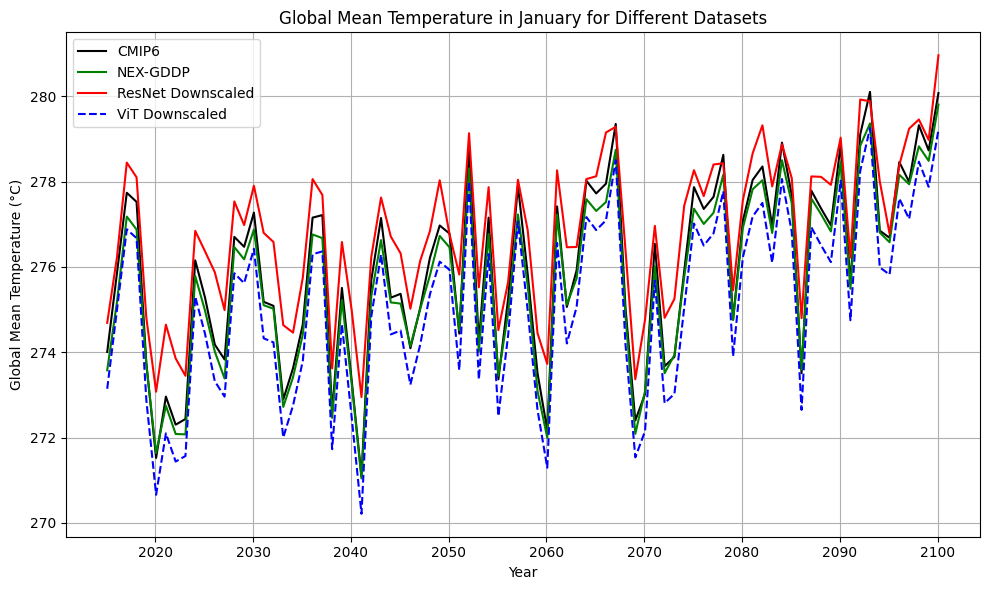

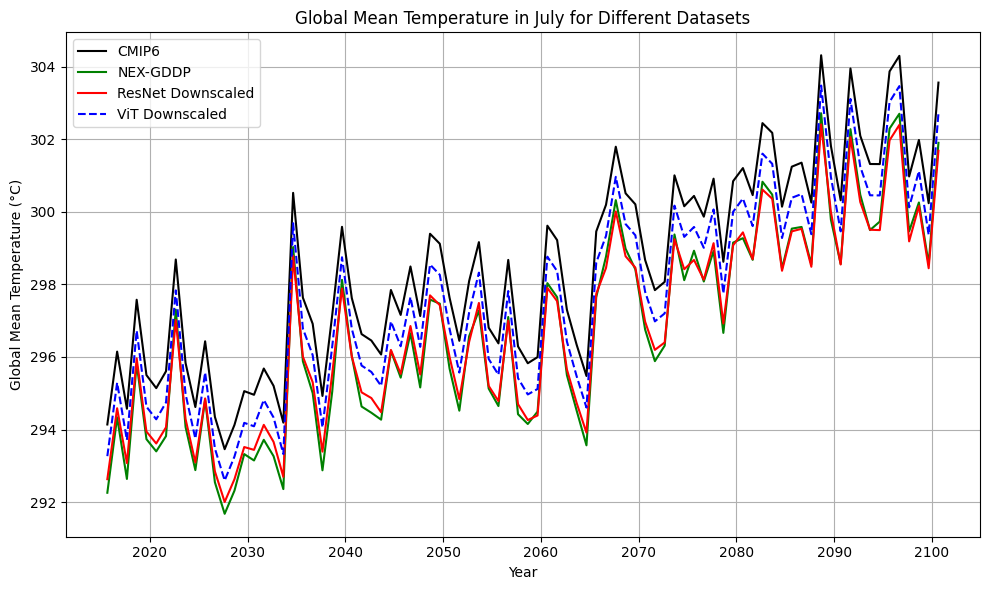

In [17]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
resnet_january = resnet_global_mean_monthly.sel(time=resnet_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(resnet_january['time'], resnet_january, label='ResNet Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
resnet_january = resnet_global_mean_monthly.sel(time=resnet_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(resnet_january['time'], resnet_january, label='ResNet Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
